# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**: Raashid Husain

**ID**:RAH383

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Downloads/BEE 4750/hw3-raashid`
   Installed InlineStrings ─────────── v1.4.2
   Installed Calculus ──────────────── v0.5.1
   Installed SentinelArrays ────────── v1.4.5
   Installed PtrArrays ─────────────── v1.2.0
   Installed StatsFuns ─────────────── v1.3.1
   Installed HypergeometricFunctions ─ v0.3.23
   Installed Pango_jll ─────────────── v1.52.2+0
   Installed TranscodingStreams ────── v0.11.1
   Installed Rmath_jll ─────────────── v0.4.2+0
   Installed QuadGK ────────────────── v2.9.4
   Installed DualNumbers ───────────── v0.6.8
   Installed Rmath ─────────────────── v0.7.1
   Installed Tables ────────────────── v1.12.0
   Installed FillArrays ────────────── v1.11.0
   Installed Distributions ─────────── v0.25.109
Precompiling project...
  ✓ PtrArrays
  ✓ Calculus
  ✓ InlineStrings
  ✓ FillArrays
  ✓ TranscodingStreams
  ✓ JLLWrappers
  ✓ SentinelArrays
  ✓ PooledArrays
  ✓ Tables
  ✓ FilePathsBase
  ✓ AliasTables
  ✓ QuadGK
  ✓ InlineStrings → Pars

In [2]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the minimum dissolved oxygen concentration up to
50km downstream and how far downriver this minimum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50km downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

Minimum DO Concentration: 2.123355628292071 mg/L at 15.0 km downstream.


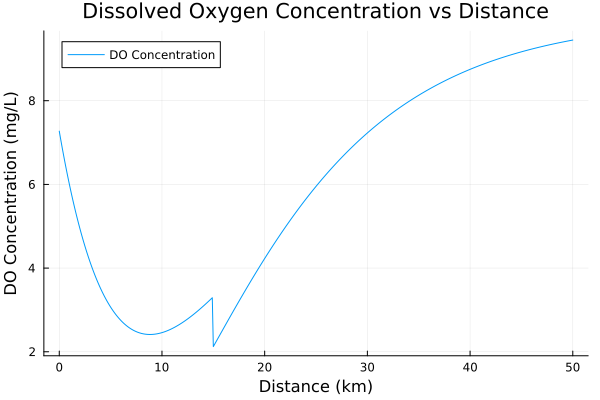

In [81]:
using Plots

river_flow_velocity = 6
reaeration_rate = 0.55
cbod_decay_rate = 0.35
nbod_decay_rate = 0.25
saturated_do_concentration = 10

inflow_river = 100000
inflow_waste1 = 10000
inflow_waste2 = 15000

do_conc_river = 7.5
do_conc_waste1 = 5
do_conc_waste2 = 5
cbod_river = 5
nbod_river = 5
cbod_waste1 = 50
cbod_waste2 = 45
nbod_waste1 = 35
nbod_waste2 = 35

distance_waste_streams = 15
max_distance = 50   

function compute_do(d)
    time = d/river_flow_velocity
    if d < distance_waste_streams
        cbod_in = (cbod_river*inflow_river + cbod_waste1*inflow_waste1)/(inflow_river + inflow_waste1)
        nbod_in = (nbod_river*inflow_river + nbod_waste1*inflow_waste1)/(inflow_river + inflow_waste1)
        
        do_initial = (do_conc_river*inflow_river + do_conc_waste1*inflow_waste1)/(inflow_river + inflow_waste1)
    else
        cbod_from_w1 = (cbod_river*inflow_river + cbod_waste1*inflow_waste1)/(inflow_river + inflow_waste1)*exp(-cbod_decay_rate*time)
        cbod_in = (cbod_from_w1*(inflow_river+inflow_waste1) + cbod_waste2*inflow_waste2)/(inflow_river + inflow_waste1 + inflow_waste2)
        nbod_from_w1 = (nbod_river*inflow_river + nbod_waste1*inflow_waste1)/(inflow_river + inflow_waste1)*exp(-nbod_decay_rate*time)
        nbod_in = (nbod_from_w1*(inflow_river+inflow_waste1) + nbod_waste2*inflow_waste2)/(inflow_river + inflow_waste1 + inflow_waste2)
        
        do_from_w1 = (do_conc_river*inflow_river + do_conc_waste1*inflow_waste1)/(inflow_river + inflow_waste1)*exp(-reaeration_rate*time)
        do_initial = (do_from_w1*(inflow_river+inflow_waste1) + do_conc_waste2*inflow_waste2)/(inflow_river + inflow_waste1 + inflow_waste2)
    end

    k1 = cbod_decay_rate + nbod_decay_rate
    k2 = reaeration_rate
    La = cbod_in + nbod_in
    
    do_defecit0 = saturated_do_concentration - do_initial
    
    d_defecit = ((k1*La)/(k2-k1))*(exp(-k1*time) - exp(-k2*time)) + do_defecit0 * exp(-k2*time)

    do_final = (saturated_do_concentration - d_defecit)

    return do_final
end

# Compute and plot DO concentration from 0 to 50 km
distances = 0:0.1:max_distance
do_concentrations = [compute_do(d) for d in distances]

min_do = minimum(do_concentrations)
min_index = argmin(do_concentrations)
min_distance = distances[min_index]

println("Minimum DO Concentration: ", min_do, " mg/L at ", min_distance, " km downstream.")

plot(distances, do_concentrations, xlabel="Distance (km)", ylabel="DO Concentration (mg/L)", title="Dissolved Oxygen Concentration vs Distance", label="DO Concentration")

##### Results and Discussion for Problem 1 Bullet Point 1

To do this problem, I split it up into the 15 km segment between the two discharges and compared the value of distance inputted into the function to 15 km. If the distance was below 15 km, I calculated the initial CBOD, NBOD, and DO using a mass balance and flow balance. If the distance was greater than 15 km, I calculated the CBOD, NBOD, and their associated kinetics to determine what the initial values for those parameters were AFTER the 15 km (so right as the second discharge was implemented). Then, using a similar mass balance and flow balance as when the distance was below 15 km, I calculated the initial CBOD, NBOD, and DO after mixing with the second discharge. Then, I used the Streeter-Phelps equation to calculate the defecit of Dissolved Oxygen with the relevant initial values calculated in the conditional statements. From the compute_do function I outputted the final DO at distance (d) using the relationship between the defecit that I calculated and the saturation level of dissolved oxygen in the river. I then plotted the results. The results reflect an oxygen sag curve as I expected, with a minimum valueof 2.12 mg/L at 15.0 meters downstream from the first discharge mixing point i.e. where the dip in the DO when the second discharged is mixed in is.

In [82]:
 function compute_do2(d, removal_waste1, removal_waste2)
    river_flow_velocity = 6
    reaeration_rate = 0.55
    cbod_decay_rate = 0.35
    nbod_decay_rate = 0.25
    saturated_do_concentration = 10

    inflow_river = 100000
    inflow_waste1 = 10000
    inflow_waste2 = 15000

    do_conc_river = 7.5
    do_conc_waste1 = 5
    do_conc_waste2 = 5
    cbod_river = 5
    nbod_river = 5
    cbod_waste1 = 50
    cbod_waste2 = 45
    nbod_waste1 = 35
    nbod_waste2 = 35

    distance_waste_streams = 15
    max_distance = 50 
     
    time = d/river_flow_velocity

    cbod_river = cbod_river # that doesn't change
    nbod_river = nbod_river
    
    cbod_waste1 = cbod_waste1 * (1 - removal_waste1)
    nbod_waste1 = nbod_waste1 * (1 - removal_waste1)

    cbod_waste2 = cbod_waste2 * (1 - removal_waste2)
    nbod_waste2 = nbod_waste2 * (1 - removal_waste2)

    if d < distance_waste_streams
        cbod_in = (cbod_river*inflow_river + cbod_waste1*inflow_waste1)/(inflow_river + inflow_waste1)
        nbod_in = (nbod_river*inflow_river + nbod_waste1*inflow_waste1)/(inflow_river + inflow_waste1)
        
        do_initial = (do_conc_river*inflow_river + do_conc_waste1*inflow_waste1)/(inflow_river + inflow_waste1)
    else
        cbod_from_w1 = (cbod_river*inflow_river + cbod_waste1*inflow_waste1)/(inflow_river + inflow_waste1)*exp(-cbod_decay_rate*time)
        cbod_in = (cbod_from_w1*(inflow_river+inflow_waste1) + cbod_waste2*inflow_waste2)/(inflow_river + inflow_waste1 + inflow_waste2)
        nbod_from_w1 = (nbod_river*inflow_river + nbod_waste1*inflow_waste1)/(inflow_river + inflow_waste1)*exp(-nbod_decay_rate*time)
        nbod_in = (nbod_from_w1*(inflow_river+inflow_waste1) + nbod_waste2*inflow_waste2)/(inflow_river + inflow_waste1 + inflow_waste2)
        
        do_from_w1 = (do_conc_river*inflow_river + do_conc_waste1*inflow_waste1)/(inflow_river + inflow_waste1)*exp(-reaeration_rate*time)
        do_initial = (do_from_w1*(inflow_river+inflow_waste1) + do_conc_waste2*inflow_waste2)/(inflow_river + inflow_waste1 + inflow_waste2)
    end

    k1 = cbod_decay_rate + nbod_decay_rate
    k2 = reaeration_rate
    La = cbod_in + nbod_in
    
    do_defecit0 = saturated_do_concentration - do_initial
    
    d_defecit = ((k1*La)/(k2-k1))*(exp(-k1*time) - exp(-k2*time)) + do_defecit0 * exp(-k2*time)

    do_final = (saturated_do_concentration - d_defecit)

    return do_final
end

# First scenario
function min_waste1(amount)
    for removal_rate in 0:0.01:1
        all_above_target = true
        for d in 0:0.1:max_distance
            if compute_do2(d, removal_rate, 0) < amount
                all_above_target = false
                break
            end
        end
        if all_above_target
            return removal_rate
        end
    end
    return 1.0
end

# Second scenario
function min_waste2(amount)
    for removal_rate in 0:0.01:1
        all_above_target = true
        for d in 0:0.1:max_distance
            if compute_do2(d, 0, removal_rate) < amount
                all_above_target = false
                break
            end
        end
        if all_above_target
            return removal_rate
        end
    end
    return 1.0 
end

min_treatment1_result = min_waste1(4)
min_treatment2_result = min_waste2(4)

println("Minimum treatment for Waste Stream 1 (% removal):", min_treatment1_result * 100)
println("Minimum treatment for Waste Stream 2 (% removal):", min_treatment2_result * 100)

Minimum treatment for Waste Stream 1 (% removal):100.0
Minimum treatment for Waste Stream 2 (% removal):100.0


##### Results and Discussion for Problem 1 Bullet Points 2 and 3

I modified the function from the first part to include the removal rate at both discharge points. I applied the removal amount to both NBOD and CBOD. I executed the same function as explained in the first part with the reduced amount of CBOD and NBOD depending on what the inputs to the function were. To get the minimum treatment percent removal, I created a few loops and conditional statements to compare the target value to the dissolved oxygen output. If the dissolved oxygen amount was less than the 4 mg/L, I created a break and the loop ended. Then the function returns the value of removal rate if the target is met, giving 100% removal rate for both discharge points. This doesn't feel like the correct answer, although I've triple checked my math and cannot find the mistake. My analysis is based off of the answer I got.

At an initial glance, I would choose to treat both of the treatment plants equally because they are both contributing to non compliance since the DO concentration dips below a concentration of 4 mg/L even before the second discharge point (although the larger dip occurs when the second discharge occurs). However, it is important to know how more information to come to a decision. For example, knowing the cost of implementing treatment at just one or both is important as econmic costs can drive project outcomes. Also, understanding the environments, ecosystems, and towns who use the river as a drinking source should also be factored in to determine where treatment should be implemented.

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [1]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

We can plot the aerosol and non-aerosol forcings below.

In [1]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path clip-path="url(#clip100)" d="M463.247 1782.41 Q459.914 1782.41 457.992 1784.19 Q456.094 1785.97 456.094 1789.1 Q456.094 1792.22 457.992 1794.01 Q459.914 1795.79 463.247 1795.79 Q466.58 1795.79 468.501 1794.01 Q470.423 1792.2 470.423 1789.1 Q470.423 1785.97 468.501 1784.19 Q466.603 1782.41 463.247 1782.41 M458.571 1780.42 Q455.562 1779.68 453.872 1777.62 Q452.205 1775.56 452.205 1772.59 Q452.205 1768.45 455.145 1766.04 Q458.108 1763.64 463.247 1763.64 Q468.409 1763.64 471.349 1766.04 Q474.288 1768.45 474.288 1772.59 Q474.288 1775.56 472.599 1777.62 Q470.932 1779.68 467.946 1780.42 Q471.326 1781.21 473.201 1783.5 Q475.099 1785.79 475.099 1789.1 Q475.099 1794.12 472.02 1796.81 Q468.964 1799.49 463.247 1799.49 Q457.529 1799.49 454.451 1796.81 Q451.395 1794.12 451.395 1789.1 Q451.395 1785.79 453.293 1783.5 Q455.191 1781.21 458.571 1780.42 M456.858 1773.03 Q456.858 1775.72 458.525 1777.22 Q460.214 1778.73 463.247 1778.73 Q466.256 1778.73 467.946 1777.22 Q469.659 1775.72 469.659 1773.03 Q469.659 1770.35 467.946 1768.84 Q466.256 1767.34 463.247 1767.34 Q460.214 1767.34 458.525 1768.84 Q456.858 1770.35 456.858 1773.03 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip100)" d="M493.409 1767.34 Q489.798 1767.34 487.969 1770.9 Q486.163 1774.45 486.163 1781.58 Q486.163 1788.68 487.969 1792.25 Q489.798 1795.79 493.409 1795.79 Q497.043 1795.79 498.849 1792.25 Q500.677 1788.68 500.677 1781.58 Q500.677 1774.45 498.849 1770.9 Q497.043 1767.34 493.409 1767.34 M493.409 1763.64 Q499.219 1763.64 502.274 1768.24 Q505.353 1772.83 505.353 1781.58 Q505.353 1790.3 502.274 1794.91 Q499.219 1799.49 493.409 1799.49 Q487.599 1799.49 484.52 1794.91 Q481.464 1790.3 481.464 1781.58 Q481.464 1772.83 484.52 1768.24 Q487.599 1763.64 493.409 1763.64 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip100)" d="M523.571 1767.34 Q519.96 1767.34 518.131 1770.9 Q516.325 1774.45 516.325 1781.58 Q516.325 1788.68 518.131 1792.25 Q519.96 1795.79 523.571 1795.79 Q527.205 1795.79 529.01 1792.25 Q530.839 1788.68 530.839 1781.58 Q530.839 1774.45 529.01 1770.9 Q527.205 1767.34 523.571 1767.34 M523.571 1763.64 Q529.381 1763.64 532.436 1768.24 Q535.515 1772.83 535.515 1781.58 Q535.515 1790.3 532.436 1794.91 Q529.381 1799.49 523.571 1799.49 Q517.76 1799.49 514.682 1794.91 Q511.626 1790.3 511.626 1781.58 Q511.626 1772.83 514.682 1768.24 Q517.76 1763.64 523.571 1763.64 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip100)" d="M1026.29 1794.89 L1042.61 1794.89 L1042.61 1798.82 L1020.66 1798.82 L1020.66 1794.89 Q1023.33 1792.13 1027.91 1787.5 Q1032.52 1782.85 1033.7 1781.51 Q1035.94 1778.98 1036.82 1777.25 Q1037.72 1775.49 1037.72 1773.8 Q1037.72 1771.04 1035.78 1769.31 Q1033.86 1767.57 1030.76 1767.57 Q1028.56 1767.57 1026.1 1768.34 Q1023.67 1769.1 1020.9 1770.65 L1020.9 1765.93 Q1023.72 1764.79 1026.17 1764.21 Q1028.63 1763.64 1030.66 1763.64 Q1036.03 1763.64 1039.23 1766.32 Q1042.42 1769.01 1042.42 1773.5 Q1042.42 1775.63 1041.61 1777.55 Q1040.83 1779.45 1038.72 1782.04 Q1038.14 1782.71 1035.04 1785.93 Q1031.94 1789.12 1026.29 1794.89 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip100)" d="M1062.42 1767.34 Q1058.81 1767.34 1056.98 1770.9 Q1055.18 1774.45 1055.18 1781.58 Q1055.18 1788.68 1056.98 1792.25 Q1058.81 1795.79 1062.42 1795.79 Q1066.06 1795.79 1067.86 1792.25 Q1069.69 1788.68 1069.69 1781.58 Q1069.69 1774.45 1067.86 1770.9 Q1066.06 1767.34 1062.42 1767.34 M1062.42 1763.64 Q1068.23 1763.64 1071.29 1768.24 Q1074.37 1772.83 1074.37 1781.58 Q1074.37 1790.3 1071.29 1794.91 Q1068.23 1799.49 1062.42 1799.49 Q1056.61 1799.49 1053.53 1794.91 Q1050.48 1790.3 1050.48 1781.58 Q1050.48 1772.83 1053.53 1768.24 Q1056.61 1763.64 1062.42 1763.64 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip100)" d="M1092.58 1767.34 Q1088.97

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

**In this problem**:

-   Assume that the treatment plan you identified in Problem 1 is still
    in place for the existing discharges. If the third discharge will
    not be treated, under the original inflow conditions (7.5 mg/L DO),
    how far downstream from the second discharge does this third
    discharge need to be placed to keep the river concentration from
    dropping below 4 mg/L?

## References

List any external references consulted, including classmates.